<a href="https://colab.research.google.com/github/alefram/notebooks/blob/master/pokedex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokedex using CNN

## Colab setup

In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 31.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


## Import Libraries

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
    
import PIL
import random
import pathlib
import datetime
import PIL.Image

import numpy as np
import matplotlib.pyplot as plt

from IPython import display

from datasets import load_dataset

# Data Setup

In [3]:
#Download data
ds = load_dataset("fcakyon/pokemon-classification", name="full")

In [4]:
# Usefull methods
def visualize_pokemons(images, labels, class_names):
    plt.figure(figsize=(10, 5))
    
    random_indices = np.random.choice(len(images), size=18, replace=False)

    for i, idx in enumerate(random_indices):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[idx].numpy().transpose((1, 2, 0)))
        plt.title(class_names[labels[idx]])
        plt.axis("off")

In [5]:
# Define data
ds = ds.with_format("torch")
train_ds = ds['train']
test_ds = ds['test']
val_ds =  ds['validation']
class_names = train_ds.features['labels'].names

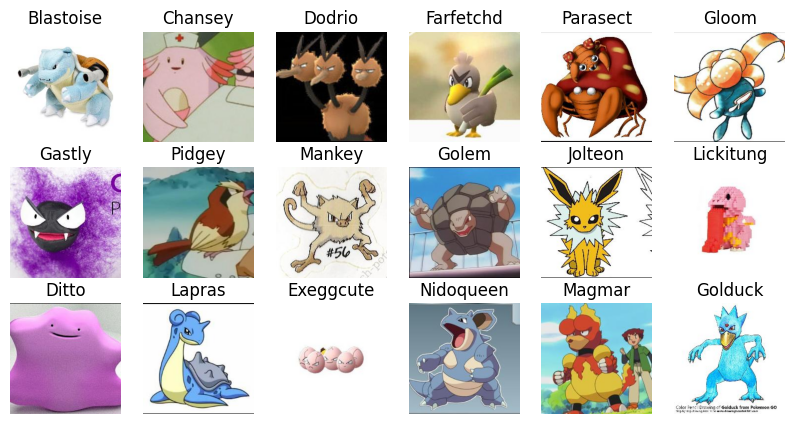

In [6]:
#visualize data
visualize_pokemons(
    images=train_ds['image'], 
    labels=train_ds['labels'], 
    class_names=class_names
) 

# Training

In [7]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [33]:
# Define neural network
class PokemonCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)   
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128*14*14, 510)
        self.fc2 = nn.Linear(510, num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)        
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2, 2)   
        x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2, 2) 
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.log_softmax(self.fc2(x))
        
        return x

model = PokemonCNN(num_classes=len(class_names)).to(device)

In [34]:
#Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14])
torch.Size([32, 25088])
torch.Size([32, 128, 14, 14]

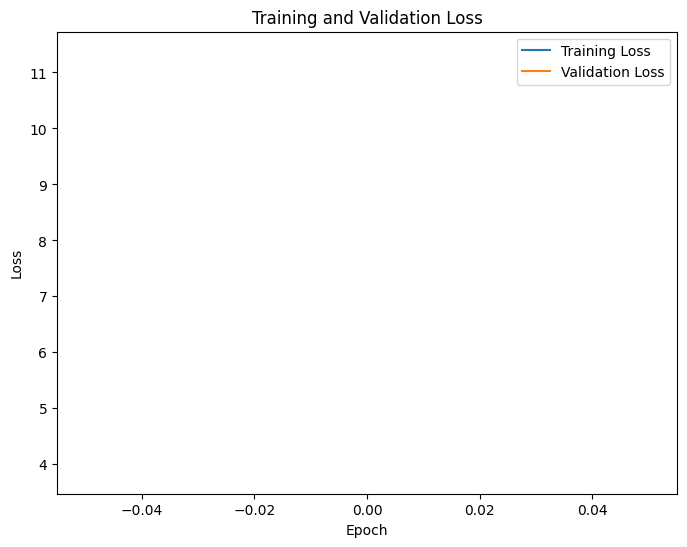

In [38]:
#TODO: fix training
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)  # Assuming you have a validation dataset
epochs = 1

train_losses = []
val_losses = []

model.train(True)
for epoch in range(epochs):
    epoch_train_loss = 0
    for idx, batch in enumerate(train_loader):
        #feedforward
        y_pred = model(batch['image'].to(torch.float32))
        
        #compute loss accuracy
        y = batch['labels']
        loss = criterion(y_pred, y)
        epoch_train_loss += loss.item()
        score, predicted = torch.max(y_pred, 1)
        acc = (y == predicted).sum().float() / len(y)
        print("[EPOCH: %i, [LOSS]: %.6f, [ACCURACY]: %.3f" % (epoch, loss.item(), acc))
        display.clear_output(wait=True)       
        
        #backward
        optimizer.zero_grad()
        loss.backward()
        
        #update params
        optimizer.step()
    
    # Calculate average training loss for the epoch
    train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(train_loss)
    
    # Evaluate on validation set
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            y_pred = model(batch['image'].to(torch.float32))
            y = batch['labels']
            loss = criterion(y_pred, y)
            epoch_val_loss += loss.item()
    
    val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(val_loss)
    
    print(f"[EPOCH: {epoch}, [TRAIN LOSS]: {train_loss:.6f}, [VAL LOSS]: {val_loss:.6f}")

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Evaluation

pokemon name:  Slowpoke label:  102


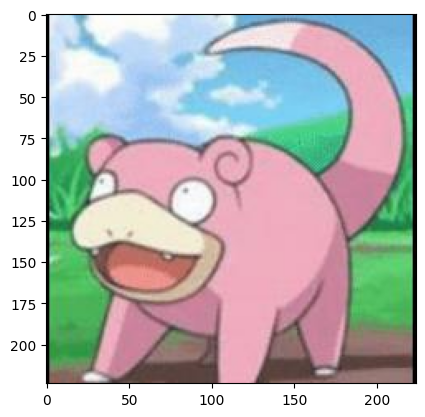

In [31]:
n = 400
image = test_ds['image'][n]
label =  test_ds['labels'][n]
print("pokemon name: ", class_names[label], "label: ", label)

plt.imshow(image.astype("uint8"))

In [32]:
#TODO: test model

This image most likely belongs to Dewgong with a 1.79 percent confidence.
